In [1]:
import numpy as np
import pandas as pd
import re,os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
metadata = pd.read_csv("/home/bruce1996/data/MCI/metadata/metadata_20221224.csv",index_col=0)
metadata['Diagnosis'] = metadata['Diagnosis'].replace("可能有MCI","MCI")
metadata['Class'] = metadata['Diagnosis'].replace("Dementia","MCI")

In [4]:
sum(metadata['Diagnosis'] == 'Normal')

215

In [20]:
metaphlan = pd.read_csv('/home/bruce1996/data/MCI/metaphlan_result/latest_format_metaphlan_table.txt',sep='\t',index_col=0)

In [21]:
mci_cluster = pd.read_csv('/home/bruce1996/data/MCI/latest_result/MCI/consensus/lacto_clustering.txt',sep='\t',index_col=0)
normal_cluster = pd.read_csv('/home/bruce1996/data/MCI/latest_result/normal/consensus/lacto_clustering.txt',sep='\t',index_col=0)
mci_cluster['cluster'] = ['MCI_' + str(x) for x in mci_cluster['cluster']]
normal_cluster['cluster'] = ['Normal_' + str(x) for x in normal_cluster['cluster']]
cluster = pd.concat([mci_cluster,normal_cluster])

In [35]:
metadata = pd.concat([metadata.loc[cluster.index,:],cluster],axis=1)
metaphlan = metaphlan.loc[:,metadata.index].fillna(0)

### prepare lefse input

In [39]:
idx = np.where(metadata['Class'] == 'MCI',True,False)
mci_metadata = metadata.loc[idx,:]
mci_metaphlan = metaphlan.loc[:,idx]
lefse_class = mci_metadata
lefse_class['cluster'] = [x.split('_')[-1] for x in lefse_class['cluster']]
lefse_class.loc[:,'Signature'] = np.where(lefse_class['cluster'] == '1','Probiotics_deficiency','With_probiotics')

/tmp/ipykernel_1138215/1717691781.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lefse_class['cluster'] = [x.split('_')[-1] for x in lefse_class['cluster']]
/home/bruce1996/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [47]:
lefse_input.to_csv('/home/bruce1996/data/MCI/latest_result/MCI/lefse/between_cluster_lefse_input.txt',sep='\t')

In [13]:
cluster_combination = [(2,3),(2,4),(3,4)]
for cb in cluster_combination :
    idx = (lefse_class["cluster"] == str(cb[0])) | (lefse_class["cluster"] == str(cb[1]))
    metadata = lefse_class.loc[idx,['cluster','Sex']].T
    matrix = normal_metaphlan.loc[:,metadata.columns]
    lefse_input = pd.concat([metadata,matrix])
    lefse_input.to_csv('/home/bruce1996/data/MCI/latest_result/normal/lefse/c%s_vs_c%s_lefse_input.txt' % cb,sep='\t')

### plot lefse res

In [14]:
def format_lefse_result(lefse_res) :
    lefse = pd.read_csv(lefse_res,sep='\t',index_col=0,header=None)
    lefse.columns = ['wilconox','class','LDA_score','kw']# type: ignore
    lefse_res = lefse.fillna(-1)
    lefse = lefse_res[lefse_res['class'] != -1]
    lefse = lefse.sort_values(by=['class','LDA_score'],ascending=False)
    lefse.index.name = None
    return lefse

In [15]:
def lefse_boxplot(lefse_input_path,lefse_res_path,fig_output,hue='cluster') :
    #processing input
    lefse_res = format_lefse_result(lefse_res_path)
    lefse_input = pd.read_csv(lefse_input_path,sep='\t',index_col=0)
    lefse_metadata = lefse_input.iloc[:2,:].T
    lefse_metaphlan = lefse_input.iloc[3:,:].fillna(0)
    #lefse res
    species = lefse_res.index
    sample = lefse_metadata.index
    lefse = lefse_metaphlan.loc[species,sample]
    sample_dict = dict(zip(sample,lefse_metadata[hue].values))
    lefse['Species'] = species
    #plot
    plot_df = lefse.melt(id_vars='Species')
    plot_df[hue] = plot_df['variable'].map(sample_dict)
    plot_df['value'] = plot_df['value'].astype('float')
    
    plt.figure(figsize=(8,5))
    sns.boxplot(data=plot_df,x='value',y='Species',hue=hue,palette='Set2',showfliers = False)
    plt.xlabel('Relative abundance (%)')
    plt.xticks(rotation=90)# type: ignore    
    plt.savefig(fig_output,dpi=300,bbox_inches='tight')

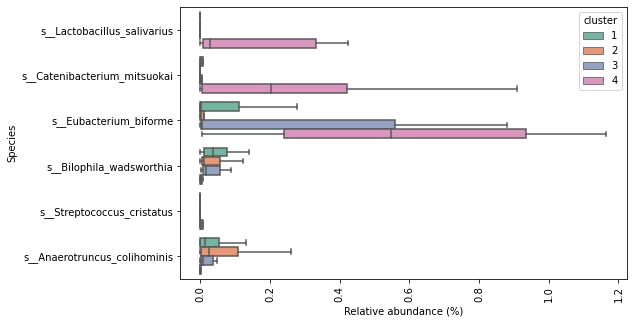

In [49]:
prefix = 'between_cluster'
lefse_res_path = '/home/bruce1996/data/MCI/latest_result/MCI/lefse/%s.res' % prefix
lefse_input_path = '/home/bruce1996/data/MCI/latest_result/MCI/lefse/%s_lefse_input.txt' % prefix
fig_output = '/home/bruce1996/data/MCI/latest_result/MCI/lefse/%s_lefse_boxplot.png' % prefix
lefse_boxplot(lefse_input_path,lefse_res_path,fig_output)

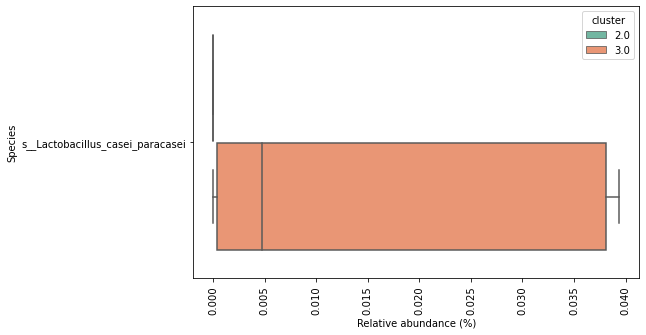

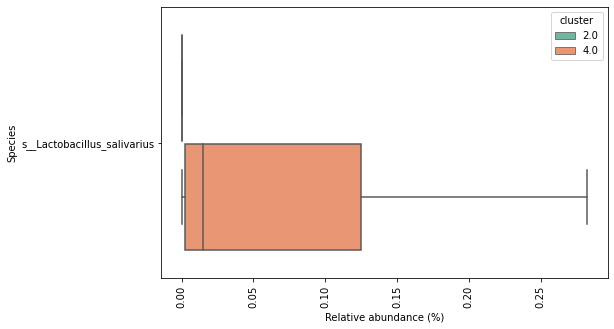

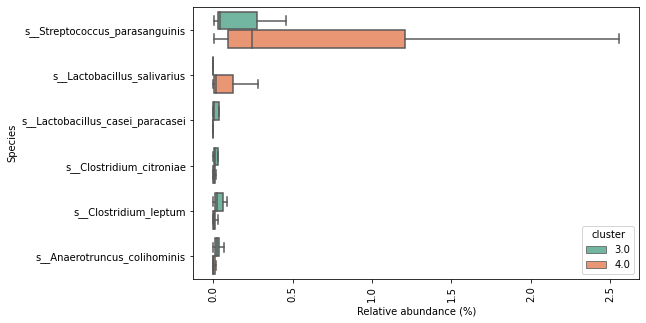

In [38]:
prefix_list=["c2_vs_c3","c2_vs_c4","c3_vs_c4"]
for prefix in prefix_list :
    lefse_res_path = '/home/bruce1996/data/MCI/latest_result/normal/lefse/%s.res' % prefix
    lefse_input_path = '/home/bruce1996/data/MCI/latest_result/normal/lefse/%s_lefse_input.txt' % prefix
    fig_output = '/home/bruce1996/data/MCI/latest_result/normal/lefse/%s_lefse_boxplot.png' % prefix
    if prefix == "c1_against_other" :
        lefse_boxplot(lefse_input_path,lefse_res_path,fig_output,hue='Signature')
    else :
        lefse_boxplot(lefse_input_path,lefse_res_path,fig_output)